#**Preliminary steps**

##Installing Conda

In [1]:
!conda --version

/bin/bash: conda: command not found


In [2]:
!pip install condacolab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# The kernel will restart after executing this cell
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:19
🔁 Restarting kernel...


In [1]:
%%capture
!conda update -n base -c conda-forge conda
!conda install openmm

In [2]:
!conda --version

conda 22.11.1


##Cloning the repository

In [3]:
%%capture
!git clone https://github.com/allenai/scidocs.git
!git clone https://github.com/allenai/specter

##Creating virtual environment and installing libraries

In [4]:
import time
import datetime
from math import floor

In [5]:
%%capture

start = time.time()

!conda create -y --name scidocs python==3.7
!conda init bash
!conda activate scidocs

!pip install pytrec_eval 'awscli<1.18.84' allennlp==0.9 overrides==3.1.0

# To avoid compatibility problems among the libraries, we take the most updated version of each library before 2020-06-18 (Last commit in scidocs repository)
#!conda install -y -q -c conda-forge numpy pandas scikit-learn=0.22.2 jsonlines tqdm sklearn-contrib-lightning pytorch
!conda install -y -q -c conda-forge \
    'numpy<1.19.0' \
    'pandas<1.1.0' \
    'scikit-learn=0.22.2' \
    'jsonlines<2.0' \
    tqdm \
    'sklearn-contrib-lightning<0.6' \
    'pytorch<1.8.0'
    #'pytorch<1.6.0' # This version cannot be found by conda, so we install a newer version that is compatible with the rest of the libraries

!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install --upgrade transformers==4.2

end = time.time()

In [6]:
print(f"Time required to install all the libraries: {datetime.timedelta(seconds=floor(end-start))}")

Time required to install all the libraries: 0:24:56


In [7]:
# Restarting runtime
exit()

In [1]:
import time
import datetime
from math import floor

##Downloading data

In [2]:
%%capture
!aws s3 sync --no-sign-request s3://ai2-s2-research-public/specter/scidocs/ data/
!pip install /content/scidocs/

In [3]:
# Adding ./scidocs/ to path so python can import libraries from this forlder
# path[0] is reserved for script path (or '' in REPL)

import sys
sys.path.insert(1, './scidocs/')

##Check if GPU is available

In [4]:
import torch

if torch.cuda.is_available():
    print("GPU is available")
    device = 0
else:
    print("GPU is NOT available")
    device = -1

print(device)

GPU is available
0


#**Reproducing results (SciDocs repository)**

In [5]:
from pprint import pprint

repository_results = {
    'mag': {'f1': 81.95},
    "mesh": {"f1": 86.44},
    "co-view": {"map": 83.63, "ndcg": 91.5},
    "co-read": {"map": 84.46, "ndcg": 92.39},
    "cite": {"map": 88.3, "ndcg": 94.88},
    "co-cite": {"map": 88.11, "ndcg": 94.77},
    "recomm": {"adj-NDCG": 53.9, "adj-P@1": 20}
}

In [6]:
%%capture
from scidocs import get_scidocs_metrics
from scidocs.paths import DataPaths

In [7]:
# Custom scidocs class with all the paths for every file in the dataset
data_paths = DataPaths()

# Embeddings jsonl files
classification_embeddings_path = 'data/specter-embeddings/cls.jsonl'
user_activity_and_citations_embeddings_path = 'data/specter-embeddings/user-citation.jsonl'
recomm_embeddings_path = 'data/specter-embeddings/recomm.jsonl'

In [8]:
start = time.time()

# Scidocs evaluation
scidocs_metrics = get_scidocs_metrics(
    data_paths,
    classification_embeddings_path,
    user_activity_and_citations_embeddings_path,
    recomm_embeddings_path,
    val_or_test='test',  # set to 'val' if tuning hyperparams
    n_jobs=12,  # the classification tasks can be parallelized
    cuda_device=device  # the recomm task can use a GPU if this is set to 0, 1, etc
)

end = time.time()

Loading MAG/MeSH embeddings...


reading embeddings from file...: 48473it [00:35, 1349.09it/s]


Running the MAG task...
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  21 out of  21 | elapsed: 10.1min finished


Running the MeSH task...
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  21 out of  21 | elapsed:  7.5min finished


Loading co-view, co-read, cite, and co-cite embeddings...


reading embeddings from file...: 142009it [01:14, 1912.67it/s]


Running the co-view, co-read, cite, and co-cite tasks...
Loading recomm embeddings...
Running the recomm task...
Testing on 1000 examples.


100%|██████████| 1000/1000 [00:45<00:00, 21.86it/s]


In [9]:
print("These two dictionaries should be identical (except 'recomm' due to a lack of PyTorch reproducibility)\n")

print("Results got in this notebook")
pprint(scidocs_metrics)

print("\nResults of last row of Table 1 in the SPECTER paper")
pprint(repository_results)

print(f"\n\nTime required to compute the metrics: {datetime.timedelta(seconds=floor(end-start))}")

These two dictionaries should be identical (except 'recomm' due to a lack of PyTorch reproducibility)

Results got in this notebook
{'cite': {'map': 88.3, 'ndcg': 94.88},
 'co-cite': {'map': 88.11, 'ndcg': 94.77},
 'co-read': {'map': 84.46, 'ndcg': 92.39},
 'co-view': {'map': 83.63, 'ndcg': 91.5},
 'mag': {'f1': 81.95},
 'mesh': {'f1': 86.44},
 'recomm': {'adj-NDCG': 53.88, 'adj-P@1': 20.01}}

Results of last row of Table 1 in the SPECTER paper
{'cite': {'map': 88.3, 'ndcg': 94.88},
 'co-cite': {'map': 88.11, 'ndcg': 94.77},
 'co-read': {'map': 84.46, 'ndcg': 92.39},
 'co-view': {'map': 83.63, 'ndcg': 91.5},
 'mag': {'f1': 81.95},
 'mesh': {'f1': 86.44},
 'recomm': {'adj-NDCG': 53.9, 'adj-P@1': 20}}


Time required to compute the metrics: 0:25:55


#**Reproducing results (Huggingface)**

##Embedding the documents

In [10]:
%%capture
# Downloading the model

from transformers import AutoTokenizer, AutoModel

# Executing this line to download the model
tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
model = AutoModel.from_pretrained('allenai/specter')


In [11]:
import json

start = time.time()

# This file is to big for Colab, so we need to split it
f = open("./data/paper_metadata_view_cite_read.json")
dic = json.load(f)
f.close()

dic_part1 = {}
dic_part2 = {}

mid_index = len(dic.keys()) / 2

for i, k in enumerate(dic.keys()):
    val = dic[k] 
    
    if i < mid_index:
        dic_part1[k] = val
    else:
        dic_part2[k] = val

f = open("./data/paper_metadata_view_cite_read_part1.json", "w")
json.dump(dic_part1, f)
f.close()

f = open("./data/paper_metadata_view_cite_read_part2.json", "w")
json.dump(dic_part2, f)
f.close()

end = time.time()
print(f"Time required to divide the view-cite-read file: {datetime.timedelta(seconds=floor(end-start))}")

Time required to divide the view-cite-read file: 0:00:40


In [12]:
# Cleaning memory
del f, dic, dic_part1, dic_part2, mid_index, i, k, val

In [13]:
start = time.time()

path_to_paper_metadata = "./data/paper_metadata_view_cite_read_part1.json"
mag_mesh_output_file_path = "view_cite_hugging_embeddings_part1.jsonl"

!CUDA_VISIBLE_DEVICES={device} python specter/scripts/embed_papers_hf.py \
    --data-path {path_to_paper_metadata} \
    --output {mag_mesh_output_file_path} \
    --batch-size 8

path_to_paper_metadata = "./data/paper_metadata_view_cite_read_part2.json"
mag_mesh_output_file_path = "view_cite_hugging_embeddings_part2.jsonl"

!CUDA_VISIBLE_DEVICES={device} python specter/scripts/embed_papers_hf.py \
    --data-path {path_to_paper_metadata} \
    --output {mag_mesh_output_file_path} \
    --batch-size 8

end = time.time()
print(f"\nTime required to embed the view-cite-read files: {datetime.timedelta(seconds=floor(end-start))}")

8876it [30:36,  4.83it/s]
8876it [32:58,  4.49it/s]              

Time required to embed the view-cite-read files: 1:06:10


In [14]:
# We must merge the two parts that we divided before
import jsonlines

start = time.time()

view_cite_output_file_path = "view_cite_hugging_embeddings.jsonl"
merged_output = jsonlines.open(view_cite_output_file_path, mode='w')

reader = jsonlines.open("./view_cite_hugging_embeddings_part1.jsonl")
merged_output.write_all(reader)
reader.close()

reader = jsonlines.open("./view_cite_hugging_embeddings_part2.jsonl")
merged_output.write_all(reader)
reader.close()

merged_output.close()

end = time.time()
print(f"Time required to merge the view-cite-read files: {datetime.timedelta(seconds=floor(end-start))}")

Time required to merge the view-cite-read files: 0:03:00


In [15]:
start = time.time()

path_to_paper_metadata = "./data/paper_metadata_mag_mesh.json"
mag_mesh_output_file_path = "mag_mesh_hugging_embeddings.jsonl"

!CUDA_VISIBLE_DEVICES={device} python specter/scripts/embed_papers_hf.py \
    --data-path {path_to_paper_metadata} \
    --output {mag_mesh_output_file_path} \
    --batch-size 8

end = time.time()
print(f"\nTime required to embed the MAG-MeSH file: {datetime.timedelta(seconds=floor(end-start))}")

6060it [23:34,  4.28it/s]              

Time required to embed the MAG-MeSH file: 0:24:29


In [16]:
start = time.time()

path_to_paper_metadata = "./data/paper_metadata_recomm.json"
recom_output_file_path = "recomm_hugging_embeddings.jsonl"

!CUDA_VISIBLE_DEVICES={device} python specter/scripts/embed_papers_hf.py \
    --data-path {path_to_paper_metadata} \
    --output {recom_output_file_path} \
    --batch-size 8

end = time.time()
print(f"\nTime required to embed the recommendation file: {datetime.timedelta(seconds=floor(end-start))}")

4533it [19:35,  3.86it/s]

Time required to embed the recommendation file: 0:20:17


##Reproducing paper results

In [17]:
from pprint import pprint

repository_results_hugging = {
    'mag': {'f1': 79.4},
    "mesh": {"f1": 87.7},
    "co-view": {"map": 83.4, "ndcg": 91.4},
    "co-read": {"map": 85.1, "ndcg": 92.7},
    "cite": {"map": 92.0, "ndcg": 96.6},
    "co-cite": {"map": 88.0, "ndcg": 94.7},
    "recomm": {"adj-NDCG": 54.6, "adj-P@1": 20.9},
    "Avg": 80.5
}

In [18]:
%%capture
from scidocs import get_scidocs_metrics
from scidocs.paths import DataPaths

In [19]:
# Custom scidocs class with all the paths for every file in the dataset
data_paths = DataPaths()

# Embeddings jsonl files
classification_embeddings_path = "mag_mesh_hugging_embeddings.jsonl"
user_activity_and_citations_embeddings_path = "view_cite_hugging_embeddings.jsonl"
recomm_embeddings_path = "recomm_hugging_embeddings.jsonl"

In [20]:
start = time.time()

# Scidocs evaluation
scidocs_metrics_hugging = get_scidocs_metrics(
    data_paths,
    classification_embeddings_path,
    user_activity_and_citations_embeddings_path,
    recomm_embeddings_path,
    val_or_test='test',  # set to 'val' if tuning hyperparams
    n_jobs=12,  # the classification tasks can be parallelized
    cuda_device=device  # the recomm task can use a GPU if this is set to 0, 1, etc
)

end = time.time()

Loading MAG/MeSH embeddings...


reading embeddings from file...: 48473it [00:24, 1980.64it/s]


Running the MAG task...
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  21 out of  21 | elapsed:  9.2min finished


Running the MeSH task...
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  21 out of  21 | elapsed:  5.9min finished


Loading co-view, co-read, cite, and co-cite embeddings...


reading embeddings from file...: 142009it [01:16, 1865.68it/s]


Running the co-view, co-read, cite, and co-cite tasks...
Loading recomm embeddings...
Running the recomm task...
Testing on 1000 examples.


100%|██████████| 1000/1000 [00:44<00:00, 22.36it/s]


In [21]:
print("These two dictionaries should be identical (except 'recomm' due to a lack of PyTorch reproducibility)\n")

print("Results got in this notebook")
pprint(scidocs_metrics_hugging)

print("\nResults of allenai/specter repository ")
pprint(repository_results_hugging)

print(f"\n\nTime required to compute the metrics: {datetime.timedelta(seconds=floor(end-start))}")

These two dictionaries should be identical (except 'recomm' due to a lack of PyTorch reproducibility)

Results got in this notebook
{'cite': {'map': 91.96, 'ndcg': 96.61},
 'co-cite': {'map': 87.9, 'ndcg': 94.69},
 'co-read': {'map': 85.11, 'ndcg': 92.73},
 'co-view': {'map': 83.36, 'ndcg': 91.37},
 'mag': {'f1': 79.43},
 'mesh': {'f1': 87.67},
 'recomm': {'adj-NDCG': 54.68, 'adj-P@1': 20.85}}

Results of allenai/specter repository 
{'Avg': 80.5,
 'cite': {'map': 92.0, 'ndcg': 96.6},
 'co-cite': {'map': 88.0, 'ndcg': 94.7},
 'co-read': {'map': 85.1, 'ndcg': 92.7},
 'co-view': {'map': 83.4, 'ndcg': 91.4},
 'mag': {'f1': 79.4},
 'mesh': {'f1': 87.7},
 'recomm': {'adj-NDCG': 54.6, 'adj-P@1': 20.9}}


Time required to compute the metrics: 0:23:13


#**Text Classification**

##Defining functions and common variables

In [22]:
mesh_labels = {
    0: 'Cardiovascular diseases',
    1: 'Chronic kidney disease',
    2: 'Chronic respiratory diseases',
    3: 'Diabetes mellitus',
    4: 'Digestive diseases',
    5: 'HIV/AIDS',
    6: 'Hepatitis A/B/C/E',
    7: 'Mental disorders',
    8: 'Musculoskeletal disorders',
    9: 'Neoplasms (cancer)',
    10: 'Neurological disorders'
}

mag_labels = {
    0: 'Art',
    1: 'Biology',
    2: 'Business',
    3: 'Chemistry',
    4: 'Computer science',
    5: 'Economics',
    6: 'Engineering',
    7: 'Environmental science',
    8: 'Geography',
    9: 'Geology',
    10: 'History',
    11: 'Materials science',
    12: 'Mathematics',
    13: 'Medicine',
    14: 'Philosophy',
    15: 'Physics',
    16: 'Political science',
    17: 'Psychology',
    18: 'Sociology'
}

In [23]:
from pprint import pprint
import os

import numpy as np
import pandas as pd
import jsonlines

from sklearn.model_selection import GridSearchCV
from lightning.classification import LinearSVC

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [69]:
# Change this value to False if you don't want to download the file
download_embeddings = True

FILEID = '1T0uhbM5MwB8oUJoDXgqLhHpDziaPJ9ec'
FILENAME = "mag_mesh_hugging_embeddings_download.jsonl"

if download_embeddings:
    command = f'''wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILEID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILEID}" -O {FILENAME} && rm -rf /tmp/cookies.txt'''
    os.system(command)

    if os.path.exists(FILENAME):
        print("File downloaded with success")
    else:
        print("File not found/Other error")


File downloaded with success


In [28]:
# This file contains all the informations about the papers used for the MAG and for the MeSH classification parts
# The Huggingface embeddings are used if the file is found.
# If they are generated in this execution time, it will use that file, otherwise he will use the downloaded file if found.
# Otherwise, the scidocs ones are used.
if os.path.exists('mag_mesh_hugging_embeddings.jsonl'):
    jsonl_file = 'mag_mesh_hugging_embeddings.jsonl'
elif os.path.exists('mag_mesh_hugging_embeddings_download.jsonl'):
    jsonl_file = 'mag_mesh_hugging_embeddings_download.jsonl'
else:
    jsonl_file = 'data/specter-embeddings/cls.jsonl'

print("jsonl_file =", jsonl_file)

start = time.time()

reader = jsonlines.open(jsonl_file)
dataset_dict = {}

for j in reader.iter():
    id = j['paper_id']

    dataset_dict[id] = j
    dataset_dict[id]["embedding"] = np.array(j["embedding"])

reader.close()

end = time.time()
print(f"Time required to read the embeddings file: {datetime.timedelta(seconds=floor(end-start))}")

jsonl_file = mag_mesh_hugging_embeddings.jsonl
Time required to read the embeddings file: 0:00:23


In [29]:
# This function link the embeddings with the labels
def get_x_y_for_classification(dataset_dict, csv_file):
    # This variable is used when the embeddings are missing
    dim = len(next(iter(dataset_dict.values()))['embedding'])

    x = []
    y = []
    missings = 0
    
    df = pd.read_csv(csv_file, header=0)
    
    for row in df.iterrows():
        pid = row[1]['pid']
        label = row[1]['class_label']
        
        if pid in dataset_dict:
            embedding = dataset_dict[pid]["embedding"]
        else:
            embedding = np.zeros(dim)
            missings += 1
        
        x.append(embedding)
        y.append(label)
    
    x = np.array(x)
    y = np.array(y)

    return x, y, missings

In [30]:
# LinearSVC is used for the classification part, just like in scidocs/scidocs/classification.py
def create_classification_model(X_train, y_train, n_jobs=-1):
    estimator = LinearSVC(loss="squared_hinge", random_state=42)
    Cs = np.logspace(-4, 2, 7)

    svm = GridSearchCV(estimator=estimator, cv=3, param_grid={'C': Cs}, verbose=1, n_jobs=n_jobs)
    svm.fit(X_train, y_train)
    
    return svm

In [31]:
def classify(model, x, y_true):
    y_pred = model.predict(x)
    
    accuracy = accuracy_score(y_true, y_pred)
    confusion = confusion_matrix(y_true, y_pred)

    precision_array = precision_score(y_true, y_pred, average=None)
    recall_array = recall_score(y_true, y_pred, average=None)
    f1_array = f1_score(y_true, y_pred, average=None)
    
    return y_pred, accuracy, confusion, precision_array, recall_array, f1_array

In [32]:
def plot_confusion_matrix(confusion, y_test_bincount, labels, title, fig_size=(13,10)):
    df_cm = pd.DataFrame(confusion * (100 / y_test_bincount), list(labels.values()), list(labels.values()))

    plt.figure(figsize=fig_size)
    color_pal = sn.color_palette("ch:start=1.6,rot=.1,dark=.35,light=0.95", as_cmap=True)

    sn.set(font_scale=1.4) # for label size
    ax = sn.heatmap(df_cm, annot=(confusion * (100 / y_test_bincount)), annot_kws={"size": 11}, cmap=color_pal, fmt=".1f", norm=LogNorm(vmax=100.0))
    ax.set(xlabel="Prediction", ylabel="True values")
    ax.set_facecolor("#ffffff")
    ax.set_title(title)

    plt.show()

##MAG

In [33]:
csv_train_file = 'data/mag/train.csv'
csv_test_file = 'data/mag/test.csv'
#csv_val_file = 'data/mag/val.csv'

labels = mag_labels

In [34]:
x_train, y_train, miss_train = get_x_y_for_classification(dataset_dict, csv_train_file)
x_test, y_test, miss_test = get_x_y_for_classification(dataset_dict, csv_test_file)
#x_val, y_val, miss_val = get_x_y_for_classification(dataset_dict, csv_val_file)

y_test_bincount = np.bincount(y_test)

print("Number of embeddings not found for the training set:", miss_train)
print("Number of embeddings not found for the test set:", miss_test)

Number of embeddings not found for the training set: 0
Number of embeddings not found for the test set: 0


In [35]:
start = time.time()

# Creating the model
svm_mag = create_classification_model(x_train, y_train)

end = time.time()
print(f"\nTime required to create the model: {datetime.timedelta(seconds=floor(end-start))}")

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  9.5min finished



Time required to create the model: 0:09:46


In [36]:
# Classifing the Test set
y_pred, accuracy, confusion, precision_array, recall_array, f1_array = classify(svm_mag, x_test, y_test)

print(f"Accuracy: {accuracy*100:2.2f}%")
print(f"F1 Score: {f1_array.mean()*100:2.2f}%", end='\n\n')

df = pd.DataFrame({
    "Label": list(labels.values()),
    "Precision": precision_array,
    "Recall": recall_array,
    "F1 score": f1_array,
    "Count": y_test_bincount
}).round(decimals=3)
df

Accuracy: 80.43%
F1 Score: 79.43%



,Label,Precision,Recall,F1 score,Count
0,Art,0.650,0.766,0.703,175
1,Biology,0.884,0.974,0.927,227
2,Business,0.839,0.827,0.833,196
3,Chemistry,0.955,0.959,0.957,197
4,Computer science,0.882,0.863,0.872,190
5,Economics,0.767,0.745,0.756,216
6,Engineering,0.853,0.918,0.884,208
7,Environmental science,0.912,0.912,0.912,216
8,Geography,0.704,0.773,0.737,172
9,Geology,0.981,0.962,0.971,212


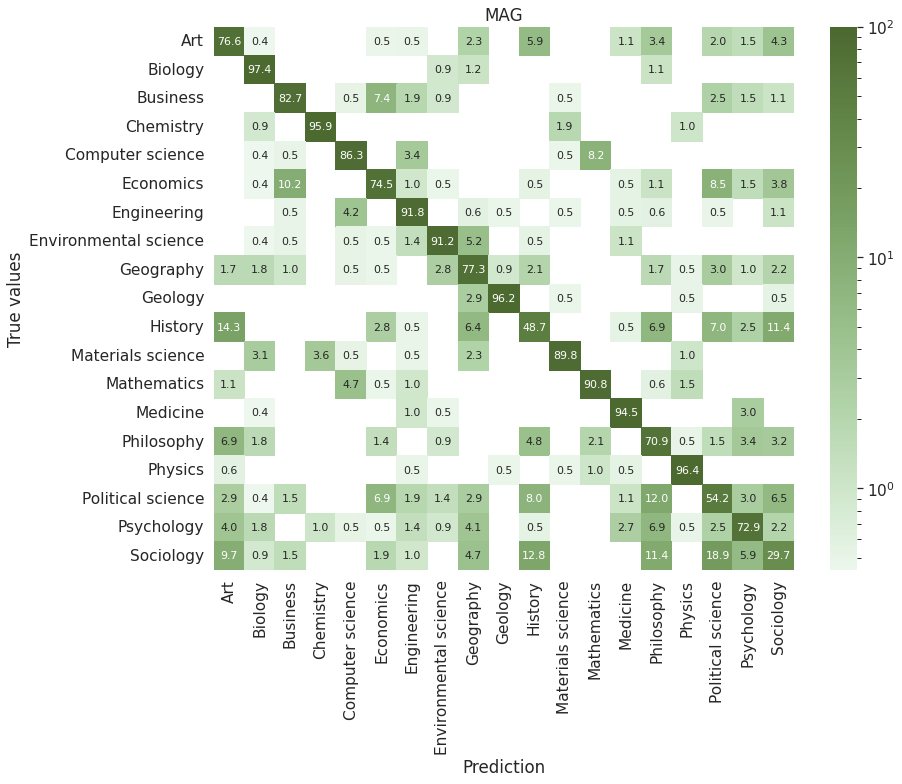

In [37]:
plot_confusion_matrix(confusion, y_test_bincount, labels, "MAG")

##MeSH

In [38]:
csv_train_file = 'data/mesh/train.csv'
csv_test_file = 'data/mesh/test.csv'
#csv_val_file = 'data/mesh/val.csv'

labels = mesh_labels

In [39]:
x_train, y_train, miss_train = get_x_y_for_classification(dataset_dict, csv_train_file)
x_test, y_test, miss_test = get_x_y_for_classification(dataset_dict, csv_test_file)
#x_val, y_val, miss_val = get_x_y_for_classification(dataset_dict, csv_val_file)

y_test_bincount = np.bincount(y_test)

print("Number of embeddings not found for the training set:", miss_train)
print("Number of embeddings not found for the test set:", miss_test)

Number of embeddings not found for the training set: 45
Number of embeddings not found for the test set: 7


In [40]:
start = time.time()

# Creating the model
svm_mesh = create_classification_model(x_train, y_train)

end = time.time()
print(f"\nTime required to create the model: {datetime.timedelta(seconds=floor(end-start))}")

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  5.8min finished



Time required to create the model: 0:05:59


In [41]:
# Classifing the Test set
y_pred, accuracy, confusion, precision_array, recall_array, f1_array = classify(svm_mesh, x_test, y_test)

print(f"Accuracy: {accuracy*100:2.2f}%")
print(f"F1 Score: {f1_array.mean()*100:2.2f}%", end='\n\n')

df = pd.DataFrame({
    "Label": list(labels.values()),
    "Precision": precision_array,
    "Recall": recall_array,
    "F1 score": f1_array,
    "Count": y_test_bincount
}).round(decimals=3)
df

Accuracy: 88.62%
F1 Score: 87.67%



,Label,Precision,Recall,F1 score,Count
0,Cardiovascular diseases,0.850,0.895,0.872,787
1,Chronic kidney disease,0.876,0.821,0.848,112
2,Chronic respiratory diseases,0.869,0.835,0.852,261
3,Diabetes mellitus,0.893,0.858,0.875,233
4,Digestive diseases,0.795,0.788,0.791,113
5,HIV/AIDS,0.964,0.882,0.922,153
6,Hepatitis A/B/C/E,0.875,0.918,0.896,61
7,Mental disorders,0.897,0.902,0.899,367
8,Musculoskeletal disorders,0.910,0.920,0.915,287
9,Neoplasms (cancer),0.917,0.927,0.922,825


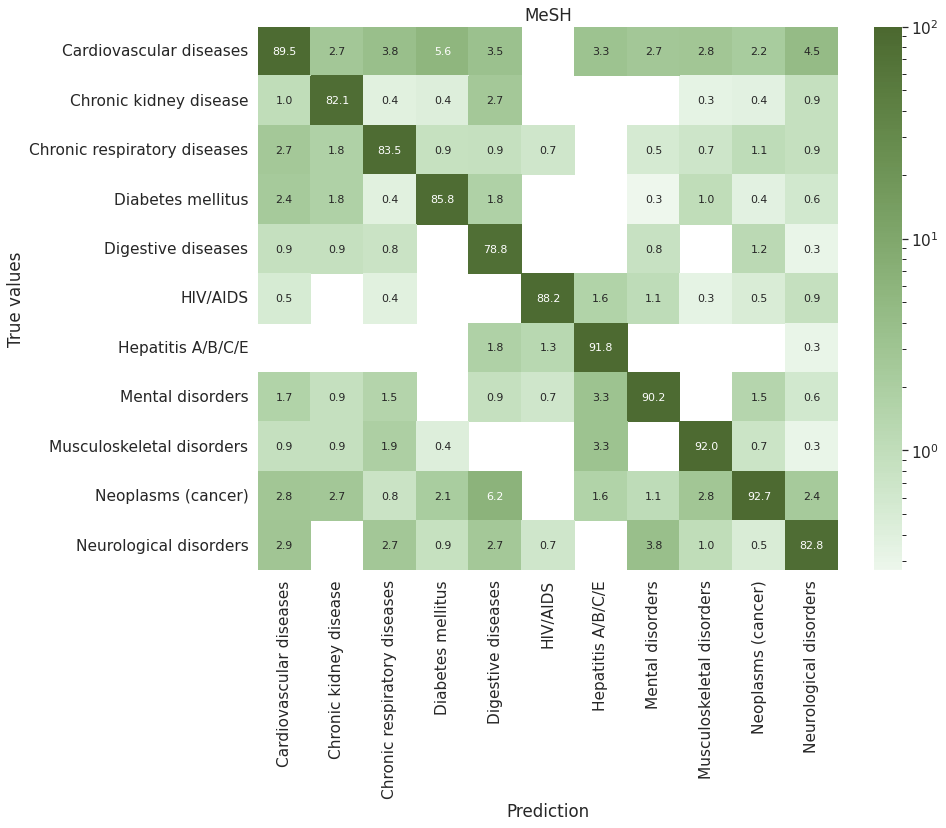

In [42]:
plot_confusion_matrix(confusion, y_test_bincount, labels, "MeSH")

##TEST (MAG)

In [ ]:
csv_train_file = 'data/mag/train.csv'
csv_test_file = 'data/mag/test.csv'
#csv_val_file = 'data/mag/val.csv'

labels = mag_labels

In [ ]:
x_train, y_train, miss_train = get_x_y_for_classification(dataset_dict, csv_train_file)
x_test, y_test, miss_test = get_x_y_for_classification(dataset_dict, csv_test_file)
#x_val, y_val, miss_val = get_x_y_for_classification(dataset_dict, csv_val_file)

y_test_bincount = np.bincount(y_test)

print("Number of embeddings not found for the training set:", miss_train)
print("Number of embeddings not found for the test set:", miss_test)

Number of embeddings not found for the training set: 0
Number of embeddings not found for the test set: 0


#Backup Stuff

In [ ]:
dataset_used = []
accuracies = []
f1s = []

# Creating the model
svm = create_classification_model(x_train, y_train)

# Classifing the Validation set
#_, accuracy, f1, _ = classify(svm, x_val, y_val)
#accuracies.append(accuracy)
#f1s.append(f1)
#dataset_used.append("Validation set")

# Classifing the Test set
y_pred, accuracy, f1, confusion = classify(svm, x_test, y_test)
accuracies.append(accuracy)
f1s.append(f1)
dataset_used.append("Test set")

df = pd.DataFrame({"Dataset": dataset_used, "Accuracy": accuracies, "F1 Score": f1s})
df

In [ ]:
# Alternative plots code
df_cm = pd.DataFrame(confusion, list(mag_labels.values()), list(mag_labels.values()))

plt.figure(figsize=fig_size)
color_pal = sn.color_palette("ch:start=1.6,rot=.1,dark=.35,light=0.95", as_cmap=True)

sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 13}, cmap=color_pal, fmt="d", norm=LogNorm())
ax.set(xlabel="Prediction", ylabel="True values")
ax.set_facecolor("#ffffff")

plt.show()

In [ ]:
df_cm = pd.DataFrame(confusion, list(mag_labels.values()), list(mag_labels.values()))

plt.figure(figsize=fig_size)
color_pal = sn.color_palette("ch:start=1.6,rot=.1,dark=.35,light=0.95", as_cmap=True)

sn.set(font_scale=1.4) # for label size
g = sn.heatmap(df_cm, annot=False, annot_kws={"size": 13}, cmap=color_pal, fmt="d", norm=LogNorm())
g.set_facecolor("#ffffff")

plt.show()